In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

import librosa
import librosa.display
import IPython.display as ipd

import seaborn

from sklearn.metrics import confusion_matrix

In [2]:
    N_TRAIN_FILES = 60         #60
    N_TEST_FILES = 11          #11
    N_VALIDATION_FILES = 3     #3
    EPOCHS = 4                 #epochs interne    
    ACC_RICHIESTA = 0.74        # 0 -> ricerca accuratezza massima per questo modello
                               # n -> termina l' addestramento al raggiungimento di questa accuratezza, poi valuta il modello e stampa il log     

    DIM_IMMAGINI = '5x5'
    N_IMAGES_FOR_FILE = 100
    SPECTRS_FOLDER = '5spectrs'
    GENERI = ['blues','classical','dubstep','house','jazz','metal','pp','rap','reggae']                   

In [3]:
#METHODS
#-------------------------------------------------------------------------------------VISUALIZZAZIONE DELLO SPETTROGRAMMA
def plot_spectrogram(Y, sr, hop_length, y_axis="linear",title=""):
    # plt.figure(figsize=(25, 10))
    plt.figure(figsize=(12, 5))
    plt.title(title)
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")
#------------------------------------------------------------------------------------
def contaPredCorrErr(valoriPredetti,valoriCorretti):
    valutazioniCorrette = 0
    valutazioniErrate = 0
    i=0
    for a in valoriCorretti:
        if a == valoriPredetti[i]:
            valutazioniCorrette+=1
        else:
            valutazioniErrate+=1
        i+=1
    
    return valutazioniCorrette,valutazioniErrate
#-------------------------------------------------------------------------------------
def shuffleTwo(a,b):
    s = np.arange(a.shape[0])
    np.random.shuffle(s)

    xris=a[s]
    yris=b[s]

    return xris,yris

#------------------------------------------------------------------------------------
def normalizza(val,min,max):
    norm = 2* (val-min)/(max-min) -1
    return norm
#------------------------------------------------------------------------------------
def normalizzaChunk(chunk,min,max):
    vT = np.vectorize(normalizza)
    i=0
    for immagine in chunk:
        chunk[i]=vT(immagine,min,max)
        i+=1
#------------------------------------------------------------------------------------
def normalizzaChunk(chunk,min,max):
    vT = np.vectorize(normalizza)
    i=0
    for immagine in chunk:
        chunk[i]=vT(immagine,min,max)
        i+=1
def plot_history(train_accuracy,test_accuracy,train_error,test_error):
    fig,axs = plt.subplots(2)
    #accuracy subplot
    axs[0].plot(train_accuracy,label='train')
    axs[0].plot(test_accuracy,label='validation')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(bbox_to_anchor=(1, 1), loc='lower right')
    # axs[0].legend(loc='lower right')
    # axs[0].set_title('Accuracy eval')

    #error subplot
    axs[1].plot(train_error,label='train error')
    axs[1].plot(test_error,label='test error')
    axs[1].set_ylabel('Error')
    axs[1].set_xlabel('Epoch')
    # axs[1].legend(bbox_to_anchor=(1.4, 1), loc='upper right')
    # axs[1].legend(loc='upper right')
    # axs[1].set_title('Error eval')

    plt.show()

In [4]:
#=========================================================
# ANALISI DEL DATASET
#=========================================================

larghezza immagini:279
altezza immagini:271

ho 60 file  di training, 11 di test e ciascuno di queti contiene 100 immagini
ogni singola immagine contiene valori di tipo: float32

stampo un' immagine di esempio:


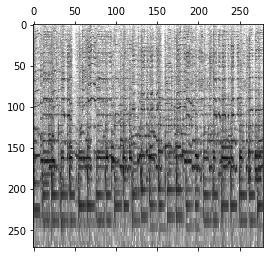

In [5]:
analizza = np.load(f'{SPECTRS_FOLDER}/{GENERI[0]}/{GENERI[0]}0.npy')
img_height=analizza.shape[1]
img_width=analizza.shape[2]

print('larghezza immagini:'+str(img_width))
print('altezza immagini:'+str(img_height))

print(f'\nho {N_TRAIN_FILES} file  di training, {N_TEST_FILES} di test e ciascuno di queti contiene {N_IMAGES_FOR_FILE} immagini')
print(f'ogni singola immagine contiene valori di tipo: {analizza[0].dtype}')
print()
print('stampo un\' immagine di esempio:')
plt.matshow(analizza[0], fignum=None)

del(analizza)

In [6]:
#=========================================================
#PREPARAZIONE MODELLO
#=========================================================

In [7]:
#batch size -> numero di samples che vengono propagati nella rete prma che essa venga aggiornata.
#epochs -> indica il numero di volte in cui ciascun batch viene propagato nella rete

# build network topology
model = keras.Sequential()

# 1st conv layer
#numero di filtri,grid size,funzione di attivazine
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height,img_width,4)))
model.add(keras.layers.MaxPooling2D((6, 6), strides=(6, 6), padding='same'))
#normalizza l' attivazione dei layer, permette di velocizzare l' addestramento
model.add(keras.layers.BatchNormalization())

# # 2nd conv layer
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))              
model.add(keras.layers.MaxPooling2D((3, 3), strides=(3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())

# 3rd conv layer
model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
#cerco di evitare l' overfitting
model.add(keras.layers.Dropout(0.5))

# output layer
model.add(keras.layers.Dense(len(GENERI), activation='softmax'))

In [8]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
#=========================================================
#VALIDATION SET
#=========================================================

In [10]:
#VALIDATION DATA
#prelevo il validation set dagli ultimi file

if N_VALIDATION_FILES!=0:

        first_val_chunk = N_TEST_FILES+N_TRAIN_FILES
        last_val_chunk = N_TEST_FILES+N_TRAIN_FILES+N_VALIDATION_FILES-1

        #carico il primo chunk del primo genere
        print(f'carico il chunk: {first_val_chunk} del genere: {GENERI[0]}')
        X_validation_temp = np.load(f'{SPECTRS_FOLDER}/{GENERI[0]}/{GENERI[0]}'+str(first_val_chunk)+'.npy')

        #carico tutti gli altri chunk del primo genere
        for chunk in range (first_val_chunk+1,last_val_chunk+1):
            print(f'carico il chunk: {chunk} del genere: {GENERI[0]}')
            temp = np.load(f'{SPECTRS_FOLDER}/{GENERI[0]}/{GENERI[0]}'+str(chunk)+'.npy')
            X_validation_temp = np.concatenate((X_validation_temp,temp))

        #carico tutti i chunk di tutti gli altri generi
        for n_genere in range (1,len(GENERI)):
            for chunk in range(first_val_chunk,last_val_chunk+1):
                 print(f'carico il chunk: {chunk} del genere: {GENERI[n_genere]}')
                 genere = np.load(f'{SPECTRS_FOLDER}/{GENERI[n_genere]}/{GENERI[n_genere]}'+str(chunk)+'.npy')
                 X_validation_temp = np.concatenate((X_validation_temp,genere))

        y_validation_temp = np.zeros(N_IMAGES_FOR_FILE*N_VALIDATION_FILES,dtype=int)
        for n_genere in range(1,len(GENERI)):
                y_validation_temp = np.concatenate((y_validation_temp,np.ones(N_IMAGES_FOR_FILE*N_VALIDATION_FILES,dtype=int)*n_genere))

        X_validation_temp,y_validation_temp = shuffleTwo(X_validation_temp,y_validation_temp)

        # X_validation_temp = tf.expand_dims(X_validation_temp, axis=-1)

        X_validation = X_validation_temp
        y_validation = y_validation_temp

        print(f'dimensione X_validation per il plot:{X_validation.shape[0]}')
        print(f'dimensione y_validation per il plot:{y_validation.shape[0]}')

        

carico il chunk: 71 del genere: blues
carico il chunk: 72 del genere: blues
carico il chunk: 73 del genere: blues
carico il chunk: 71 del genere: classical
carico il chunk: 72 del genere: classical
carico il chunk: 73 del genere: classical
carico il chunk: 71 del genere: dubstep
carico il chunk: 72 del genere: dubstep
carico il chunk: 73 del genere: dubstep
carico il chunk: 71 del genere: house
carico il chunk: 72 del genere: house
carico il chunk: 73 del genere: house
carico il chunk: 71 del genere: jazz
carico il chunk: 72 del genere: jazz
carico il chunk: 73 del genere: jazz
carico il chunk: 71 del genere: metal
carico il chunk: 72 del genere: metal
carico il chunk: 73 del genere: metal
carico il chunk: 71 del genere: pp
carico il chunk: 72 del genere: pp
carico il chunk: 73 del genere: pp
carico il chunk: 71 del genere: rap
carico il chunk: 72 del genere: rap
carico il chunk: 73 del genere: rap
carico il chunk: 71 del genere: reggae
carico il chunk: 72 del genere: reggae
carico il 

In [11]:
#=========================================================
#ADDESTRAMENTO
#=========================================================

In [12]:
#RICERCA MASSIMA ACCURATEZZA POSSIBILE

if ACC_RICHIESTA == 0:

    train_accuracy = []
    test_accuracy = []
    train_error = []
    test_error = []

    max_val_accuracy = 0.0

    for n_epoch in range(EPOCHS):
        for chunk_number in range(N_TRAIN_FILES):
            print(f'\nepoch:{n_epoch} chunk:{chunk_number}')
            #-----------------------------------------------------------------X_train_temp
            #inizialmente equivale al chunk del genere 0 (blues), poi gli concateno tutti gli altri generi con questo chunk_number
            X_train_temp = np.load(f'{SPECTRS_FOLDER}/{GENERI[0]}/{GENERI[0]}'+str(chunk_number)+'.npy')
            for n_genere in range (1,len(GENERI)):
                genere = np.load(f'{SPECTRS_FOLDER}/{GENERI[n_genere]}/{GENERI[n_genere]}'+str(chunk_number)+'.npy')
                X_train_temp = np.concatenate((X_train_temp,genere))

            #-----------------------------------------------------------------y_train_temp
            y_train_temp = np.zeros(N_IMAGES_FOR_FILE,dtype=int)
            for n_genere in range(1,len(GENERI)):
                y_train_temp = np.concatenate((y_train_temp,np.ones(N_IMAGES_FOR_FILE,dtype=int)*n_genere))

            #-----------------------------------------------------------------X_train, y_train
            X_train,y_train=shuffleTwo(X_train_temp,y_train_temp)
            #aggiungo una dimensione ad X_train, questo e' necessario per come funziona keras
            # X_train = tf.expand_dims(X_train, axis=-1)

            #---------------------------------------------------------------------------------------------------------------------------------------------salva nel grafico tutti i punti per ogni epoch
            history=model.fit(X_train, y_train, epochs=1,batch_size=32,validation_data=(X_validation,y_validation))

            #prendo i valori ottenuti dalle epoch 0 e da quella centrale
            train_accuracy.append(history.history['accuracy'])

            test_accuracy.append(history.history['val_accuracy'])
                
            train_error.append(history.history['loss'])

            test_error.append(history.history['val_loss'])

            if history.history['val_accuracy'][0] > max_val_accuracy: max_val_accuracy=history.history['val_accuracy'][0]
            print(f'massima accuratezza raggiunta:{max_val_accuracy}')

            del(history)

In [13]:
if ACC_RICHIESTA == 0: plot_history(train_accuracy,test_accuracy,train_error,test_error)

In [14]:
#se ho eseguito il blocco precedente utilizzo la massima accuratezza possibile individuata
if ACC_RICHIESTA == 0.0:
    ACC_RICHIESTA = max_val_accuracy

In [15]:
print('addestro la rete finche non ha accuratezza: '+str(ACC_RICHIESTA))

addestro la rete finche non ha accuratezza: 0.74


In [16]:
train_accuracy = []
test_accuracy = []
train_error = []
test_error = []

max_local_val_accuracy = 0.0
for n_epoch in range(100):
    if max_local_val_accuracy >= ACC_RICHIESTA: break
    for chunk_number in range(N_TRAIN_FILES):
        print(f'\nepoch:{n_epoch} chunk:{chunk_number}')
        #-----------------------------------------------------------------X_train_temp
        #inizialmente equivale al chunk del genere 0 (blues), poi gli concateno tutti gli altri generi con questo chunk_number
        X_train_temp = np.load(f'{SPECTRS_FOLDER}/{GENERI[0]}/{GENERI[0]}'+str(chunk_number)+'.npy')
        for n_genere in range (1,len(GENERI)):
            genere = np.load(f'{SPECTRS_FOLDER}/{GENERI[n_genere]}/{GENERI[n_genere]}'+str(chunk_number)+'.npy')
            X_train_temp = np.concatenate((X_train_temp,genere))

        #-----------------------------------------------------------------y_train_temp
        y_train_temp = np.zeros(N_IMAGES_FOR_FILE,dtype=int)
        for n_genere in range(1,len(GENERI)):
            y_train_temp = np.concatenate((y_train_temp,np.ones(N_IMAGES_FOR_FILE,dtype=int)*n_genere))

        #-----------------------------------------------------------------X_train, y_train
        X_train,y_train=shuffleTwo(X_train_temp,y_train_temp)
        #aggiungo una dimensione ad X_train, questo e' necessario per come funziona keras
        # X_train = tf.expand_dims(X_train, axis=-1)

        #---------------------------------------------------------------------------------------------------------------------------------------------salva nel grafico tutti i punti per ogni epoch
        history=model.fit(X_train, y_train, epochs=1,batch_size=32,validation_data=(X_validation,y_validation))

        #se voglio addestrare un modello guardo se ho raggiunto l' accuratezza richiesta

        if history.history['val_accuracy'][0] > max_local_val_accuracy: max_local_val_accuracy=history.history['val_accuracy'][0]
        print(f'massima accuratezza raggiunta localmente: {max_local_val_accuracy}')

        #prendo i valori ottenuti dalle epoch 0 e da quella centrale
        train_accuracy.append(history.history['accuracy'])
        test_accuracy.append(history.history['val_accuracy'])  
        train_error.append(history.history['loss'])
        test_error.append(history.history['val_loss'])

        if max_local_val_accuracy >= ACC_RICHIESTA: break

        del(history)

=============] - 19s 667ms/step - loss: 1.6618 - accuracy: 0.3856 - val_loss: 2.3620 - val_accuracy: 0.1589
massima accuratezza raggiunta localmente: 0.15888889133930206

epoch:0 chunk:5
29/29 [==============================] - 20s 703ms/step - loss: 1.5716 - accuracy: 0.4344 - val_loss: 2.4085 - val_accuracy: 0.1433
massima accuratezza raggiunta localmente: 0.15888889133930206

epoch:0 chunk:6
29/29 [==============================] - 20s 676ms/step - loss: 1.6126 - accuracy: 0.4167 - val_loss: 2.3964 - val_accuracy: 0.1537
massima accuratezza raggiunta localmente: 0.15888889133930206

epoch:0 chunk:7
29/29 [==============================] - 19s 670ms/step - loss: 1.5303 - accuracy: 0.4122 - val_loss: 2.4321 - val_accuracy: 0.1259
massima accuratezza raggiunta localmente: 0.15888889133930206

epoch:0 chunk:8
29/29 [==============================] - 21s 740ms/step - loss: 1.4714 - accuracy: 0.4656 - val_loss: 2.4321 - val_accuracy: 0.1211
massima accuratezza raggiunta localmente: 0.1588

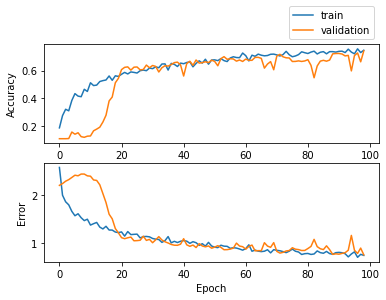

In [17]:
plot_history(train_accuracy,test_accuracy,train_error,test_error)

In [18]:
#=========================================================
#TEST SUL VALIDATION SET
#=========================================================

analizzo il modello sul chunk:71
analizzo il modello sul chunk:72
analizzo il modello sul chunk:73


valutazioni corrette: 2000
valutazioni errate: 700
precisione:0.7407407407407407


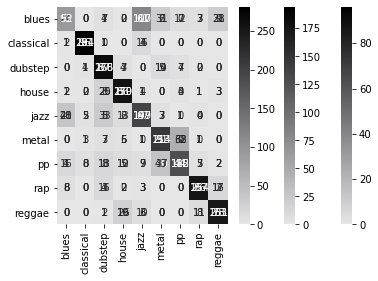

In [19]:
valutazioniCorrette = 0
valutazioniErrate = 0

for n in range (N_VALIDATION_FILES):

    nchunk = N_TEST_FILES+N_TRAIN_FILES+n

    print(f'analizzo il modello sul chunk:{nchunk}')

    #-----------------------------------------------------------------X_val_temp
    #carico il nuovo chunk del primo genere (blues)
    X_val_temp = np.load(f'{SPECTRS_FOLDER}/{GENERI[0]}/{GENERI[0]}'+str(nchunk)+'.npy')
    #poi carico il nuovo chunk di tutti gli altri generi
    for n_genere in range (1,len(GENERI)):
        genere = np.load(f'{SPECTRS_FOLDER}/{GENERI[n_genere]}/{GENERI[n_genere]}'+str(nchunk)+'.npy')
        X_val_temp = np.concatenate((X_val_temp,genere))

    #-----------------------------------------------------------------y_val_temp
    y_val_temp = np.zeros(N_IMAGES_FOR_FILE,dtype=int)
    for n_genere in range(1,len(GENERI)):
        y_val_temp = np.concatenate((y_val_temp,np.ones(N_IMAGES_FOR_FILE,dtype=int)*n_genere))

    #-----------------------------------------------------------------X_val, y_val
    X_val,y_val = shuffleTwo(X_val_temp,y_val_temp)
    # X_val = tf.expand_dims(X_val, axis=-1)
    #-----------------------------------------------------------------conteggi per valutazione modello
    #predizioni come probabilita' per ogni classe
    probPreds = model.predict(X_val)
    #predizione come classe con piu' altra probabilita' 
    testPreds = np.array([],dtype=int)
    for i in range(len(X_val)):
        testPreds=np.append(testPreds,np.argmax(probPreds[i]))

    #aggiorno il conteggio della valutazioni corrette e di quelle errate
    valut_corr,valut_err = contaPredCorrErr(testPreds,y_val)
    valutazioniCorrette+=valut_corr
    valutazioniErrate+=valut_err

#man mano calcolo le matrici di confusione e le somme nella totale
    if n==0:
        cm = confusion_matrix(y_val,testPreds)
    else:
        cm_temp = confusion_matrix(y_val,testPreds)
        cm+=cm_temp

    #gray scale
    cmap = seaborn.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
    #nomi dei generi
    seaborn.heatmap(cm,annot=True,fmt="d",cmap=cmap,xticklabels=GENERI,yticklabels=GENERI)

    #volendo potrei utilizzare questa funzione per valutare la precisione del modello, il problema e' che ho tanti dati e quindi lo posso usare solamente sui chunk, non sul totale delle
    #previsioni,quindi ho deciso di usare il sistema dei conteggi per poi calcolare la precisione in modo manuale
    # test_loss, test_acc = model.evaluate(X_val, y_val)
    # print(f"Test Accuracy: {test_acc}")

#-----------------------------------------------------------------valutazione modello
precisioneValidationSet = valutazioniCorrette/(valutazioniCorrette+valutazioniErrate)
print(f'\n\nvalutazioni corrette: {valutazioniCorrette}')
print(f'valutazioni errate: {valutazioniErrate}')
print(f'precisione:{precisioneValidationSet}')

In [20]:
#=========================================================
#TEST SUL TEST SET
#=========================================================

analizzo il modello sul chunk:60
analizzo il modello sul chunk:61
analizzo il modello sul chunk:62
analizzo il modello sul chunk:63
analizzo il modello sul chunk:64
analizzo il modello sul chunk:65
analizzo il modello sul chunk:66
analizzo il modello sul chunk:67
analizzo il modello sul chunk:68
analizzo il modello sul chunk:69
analizzo il modello sul chunk:70


valutazioni corrette: 7574
valutazioni errate: 2326
precisione:0.7650505050505051


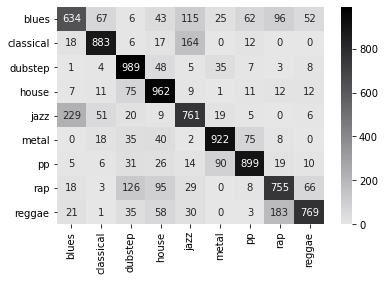

In [21]:
if ACC_RICHIESTA!=0:
    valutazioniCorrette = 0
    valutazioniErrate = 0


    for nchunk in range (N_TEST_FILES):
        #-----------------------------------------------------------------X_test_temp
        #carico il nuovo chunk del primo genere (blues)
        X_test_temp = np.load(f'{SPECTRS_FOLDER}/{GENERI[0]}/{GENERI[0]}'+str(nchunk+N_TRAIN_FILES)+'.npy')
        print(f'analizzo il modello sul chunk:{nchunk+N_TRAIN_FILES}')
        #poi carico i chunk di tutti gli altri generi
        for n_genere in range (1,len(GENERI)):
            genere = np.load(f'{SPECTRS_FOLDER}/{GENERI[n_genere]}/{GENERI[n_genere]}'+str(nchunk+N_TRAIN_FILES)+'.npy')
            X_test_temp = np.concatenate((X_test_temp,genere))
    
        #-----------------------------------------------------------------y_test_temp
        y_test_temp = np.zeros(N_IMAGES_FOR_FILE,dtype=int)
        for n_genere in range(1,len(GENERI)):
            y_test_temp = np.concatenate((y_test_temp,np.ones(N_IMAGES_FOR_FILE,dtype=int)*n_genere))

        #-----------------------------------------------------------------xtest, y_test
        X_test,y_test = shuffleTwo(X_test_temp,y_test_temp)
        # X_test = tf.expand_dims(X_test, axis=-1)
        #-----------------------------------------------------------------conteggi per valutazione modello
        #predizioni come probabilita' per ogni classe
        probPreds = model.predict(X_test)

        #predizione come classe con piu' altra probabilita' 
        testPreds = np.array([],dtype=int)
        for i in range(len(X_test)):
            testPreds=np.append(testPreds,np.argmax(probPreds[i]))

        #aggiorno il conteggio della valutazioni corrette e di quelle errate
        valut_corr,valut_err = contaPredCorrErr(testPreds,y_test)
        valutazioniCorrette+=valut_corr
        valutazioniErrate+=valut_err

    #man mano calcolo le matrici di confusione e le somme nella totale
        if nchunk==0:
            cm = confusion_matrix(y_test,testPreds)
        else:
            cm_temp = confusion_matrix(y_test,testPreds)
            cm+=cm_temp

    #grayscale
    cmap = seaborn.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
    #nomi dei generi
    seaborn.heatmap(cm,annot=True,fmt="d",cmap=cmap,xticklabels=GENERI,yticklabels=GENERI)

        #volendo potrei utilizzare questa funzione per valutare la precisione del modello, il problema e' che ho tanti dati e quindi lo posso usare solamente sui chunk, non sul totale delle
        #previsioni,quindi ho deciso di usare il sistema dei conteggi per poi calcolare la precisione in modo manuale
        # test_loss, test_acc = model.evaluate(X_test, y_test)
        # print(f"Test Accuracy: {test_acc}")

    #-----------------------------------------------------------------valutazione modello
    precisioneTestSet = valutazioniCorrette/(valutazioniCorrette+valutazioniErrate)
    print(f'\n\nvalutazioni corrette: {valutazioniCorrette}')
    print(f'valutazioni errate: {valutazioniErrate}')
    print(f'precisione:{precisioneTestSet}')

In [22]:
#=========================================================
#TEST SUL TRAININIG SET
#=========================================================

analizzo il modello sul chunk:0
analizzo il modello sul chunk:1
analizzo il modello sul chunk:2
analizzo il modello sul chunk:3
analizzo il modello sul chunk:4
analizzo il modello sul chunk:5
analizzo il modello sul chunk:6
analizzo il modello sul chunk:7
analizzo il modello sul chunk:8
analizzo il modello sul chunk:9
analizzo il modello sul chunk:10
analizzo il modello sul chunk:11
analizzo il modello sul chunk:12
analizzo il modello sul chunk:13
analizzo il modello sul chunk:14
analizzo il modello sul chunk:15
analizzo il modello sul chunk:16
analizzo il modello sul chunk:17
analizzo il modello sul chunk:18
analizzo il modello sul chunk:19
analizzo il modello sul chunk:20
analizzo il modello sul chunk:21
analizzo il modello sul chunk:22
analizzo il modello sul chunk:23
analizzo il modello sul chunk:24
analizzo il modello sul chunk:25
analizzo il modello sul chunk:26
analizzo il modello sul chunk:27
analizzo il modello sul chunk:28
analizzo il modello sul chunk:29
analizzo il modello 

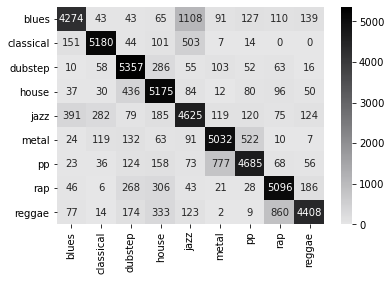

In [23]:
if ACC_RICHIESTA!=0:

    valutazioniCorrette = 0
    valutazioniErrate = 0

    for nchunk in range (N_TRAIN_FILES):

        print(f'analizzo il modello sul chunk:{nchunk}')

        #-----------------------------------------------------------------X_train_temp
        #carico il nuovo chunk del primo genere (blues)
        X_train_temp = np.load(f'{SPECTRS_FOLDER}/{GENERI[0]}/{GENERI[0]}'+str(nchunk)+'.npy')
        #poi carico il nuovo chunk di tutti gli altri generi
        for n_genere in range (1,len(GENERI)):
            genere = np.load(f'{SPECTRS_FOLDER}/{GENERI[n_genere]}/{GENERI[n_genere]}'+str(nchunk)+'.npy')
            X_train_temp = np.concatenate((X_train_temp,genere))

        #-----------------------------------------------------------------y_train_temp
        y_train_temp = np.zeros(N_IMAGES_FOR_FILE,dtype=int)
        for n_genere in range(1,len(GENERI)):
            y_train_temp = np.concatenate((y_train_temp,np.ones(N_IMAGES_FOR_FILE,dtype=int)*n_genere))

        #-----------------------------------------------------------------X_train, y_train
        X_train,y_train = shuffleTwo(X_train_temp,y_train_temp)
        # X_train = tf.expand_dims(X_train, axis=-1)
        #-----------------------------------------------------------------conteggi per valutazione modello
        #predizioni come probabilita' per ogni classe
        probPreds = model.predict(X_train)
        #predizione come classe con piu' altra probabilita' 
        testPreds = np.array([],dtype=int)
        for i in range(len(X_train)):
            testPreds=np.append(testPreds,np.argmax(probPreds[i]))

        #aggiorno il conteggio della valutazioni corrette e di quelle errate
        valut_corr,valut_err = contaPredCorrErr(testPreds,y_train)
        valutazioniCorrette+=valut_corr
        valutazioniErrate+=valut_err

    #man mano calcolo le matrici di confusione e le somme nella totale
        if nchunk==0:
            cm = confusion_matrix(y_train,testPreds)
        else:
            cm_temp = confusion_matrix(y_train,testPreds)
            cm+=cm_temp

    #grayscale
    cmap = seaborn.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
    #nomi dei generi
    seaborn.heatmap(cm,annot=True,fmt="d",cmap=cmap,xticklabels=GENERI,yticklabels=GENERI)

        #volendo potrei utilizzare questa funzione per valutare la precisione del modello, il problema e' che ho tanti dati e quindi lo posso usare solamente sui chunk, non sul totale delle
        #previsioni,quindi ho deciso di usare il sistema dei conteggi per poi calcolare la precisione in modo manuale
        # test_loss, test_acc = model.evaluate(X_train, y_train)
        # print(f"Test Accuracy: {test_acc}")

    #-----------------------------------------------------------------valutazione modello
    precisioneTrainSet = valutazioniCorrette/(valutazioniCorrette+valutazioniErrate)
    print(f'\n\nvalutazioni corrette: {valutazioniCorrette}')
    print(f'valutazioni errate: {valutazioniErrate}')
    print(f'precisione:{precisioneTrainSet}')

In [24]:
with open('log.txt','a')as log:
    log.write(f'dimensione immagini: {DIM_IMMAGINI}\n')
    log.write(f'TOT FILES: {N_TRAIN_FILES+N_TEST_FILES+N_VALIDATION_FILES}\n')
    log.write(f'TRAIN FILES: {N_TRAIN_FILES}\n')
    log.write(f'VALIDATION FILES: {N_TEST_FILES}\n')
    log.write(f'TEST FILES: {  N_TEST_FILES}\n')
    log.write(f'EPOCHS: {EPOCHS}\n\n')

    log.write(f'PRECISIONE VALIDATION SET: {precisioneValidationSet}\n')
    log.write(f'PRECISIONE TEST SET: {precisioneTestSet}\n')
    log.write(f'PRECISIONE TRAIN SET: {precisioneTrainSet}\n\n')

    model.summary(print_fn=lambda x: log.write(x + '\n'))

    log.write('\n\n\n')
    log.write(f'//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////')
    log.write('\n\n\n\n')

In [25]:
print('END')

END


In [26]:
# model.save('./model')

In [27]:
# model = keras.model.load_model('percorso')